# **Introduction**

One of the important ways humans display emotions is through facial expressions. Facial expression recognition is one of the most powerful, natural and immediate means for human beings to communicate their emotions and intensions. Humans can be in some circumstances restricted from showing their emotions, such as hospitalized patients, or due to deficiencies; hence, better recognition of other human emotions will lead to effective communication. Automatic human emotion recognition has received much attention recently with the introduction of IOT and smart environments at hospitals, smart homes and smart cities. Intelligent personal assistants (IPAs), such as Siri, Alexia, Cortana and others, use natural language processing to communicate with humans, but when augmented with emotions, it increases the level of effective communication and human-level intelligence.

![](https://ars.els-cdn.com/content/image/1-s2.0-S235291482030201X-gr1.jpg)

A convolutional neural network was used in our system to obtain improved facial emotion detection as it is applied to other computer fields such as face recognition and object detection. In addition, predictions are based on information given at a particular time.

Fig shows the network structure that is used for emotion detection using facial landmarks. This network takes an input image and attempts to predict the output emotion.

![](https://ars.els-cdn.com/content/image/1-s2.0-S235291482030201X-gr6.jpg)

Load data

**Import libraries**

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerato
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
"C:\Users\Probook\Documents\graduation project\Dataset\Autistic Children Emotions - Dr. Fatma M. Talaat\Train"

# **Load Data and Plot Samples**

In [11]:
TRAIN_DIR = ("C:\\Users\\Probook\\Documents\\graduation project\\Dataset\\Autistic Children Emotions\\Train")
TEST_DIR = ("C:\\Users\\Probook\\Documents\\graduation project\\Dataset\Autistic Children Emotions\\Test")

In [2]:
TRAIN_DIR = ("C:\\Users\\Probook\\Documents\\graduation project\\Dataset\\Autistic Children Emotions - Dr. Fatma M. Talaat\\Train")
TEST_DIR = ("C:\\Users\\Probook\\Documents\\graduation project\\Dataset\\Autistic Children Emotions - Dr. Fatma M. Talaat\\Test")

In [3]:
IMG_SIZE= (48, 48)

In [4]:
def load_data(dir_path, IMG_SIZE):
    X = []
    y = []
    i = 0
    labels = dict()

    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            folder_path = os.path.join(dir_path, path)  # Correctly join the path

            for file in os.listdir(folder_path):
                if not file.startswith('.'):
                    file_path = os.path.join(folder_path, file)  # Correctly join the path
                    img = cv2.imread(file_path)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1

    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


In [5]:
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)

100%|██████████| 6/6 [00:16<00:00,  2.79s/it]

758 images loaded from C:\Users\Probook\Documents\graduation project\Dataset\Autistic Children Emotions - Dr. Fatma M. Talaat\Train directory.


In [6]:
train_labels

{0: 'Natural', 1: 'anger', 2: 'fear', 3: 'joy', 4: 'sadness', 5: 'surprise'}

In [7]:
X_test, y_test, test_labels = load_data(TEST_DIR,IMG_SIZE)

100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

75 images loaded from C:\Users\Probook\Documents\graduation project\Dataset\Autistic Children Emotions - Dr. Fatma M. Talaat\Test directory.


In [14]:
def plot_samples(X, y, labels_dict, n=50):
   
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(10,3))
        c = 1
        for img in imgs:
            plt.imshow(img[0])
            plt.subplot(i,j,c)
            

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle(labels_dict[index])
        plt.show()

C:\Users\Probook\AppData\Local\Temp\ipykernel_12152\3690626564.py:12: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



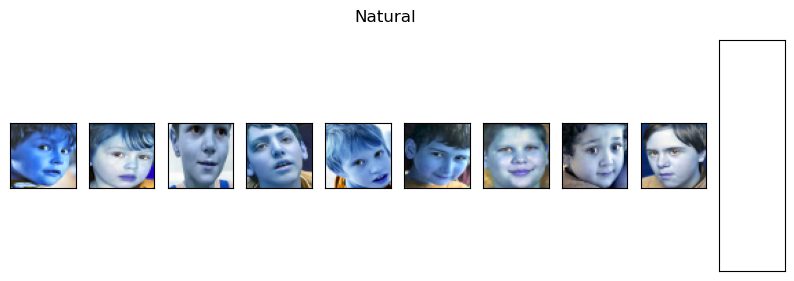

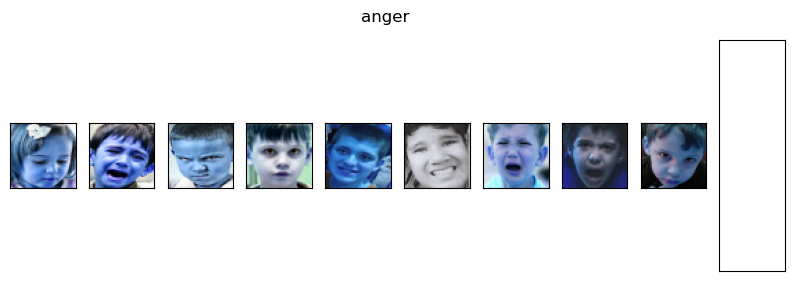

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


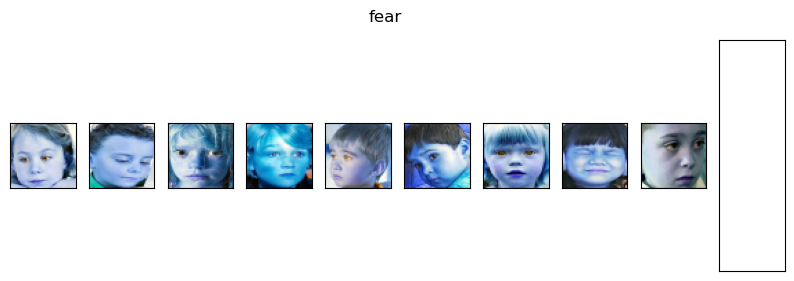

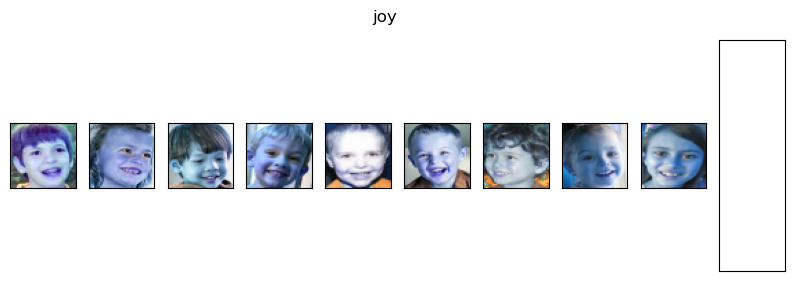

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


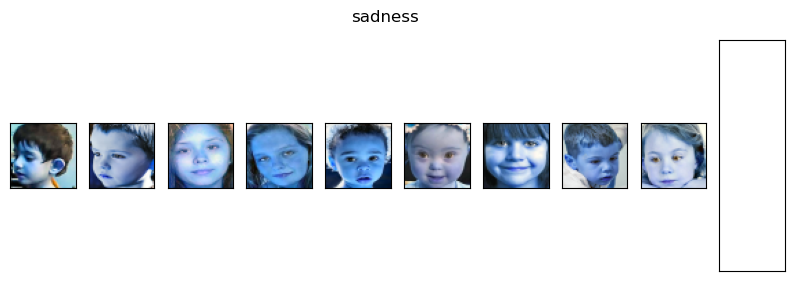

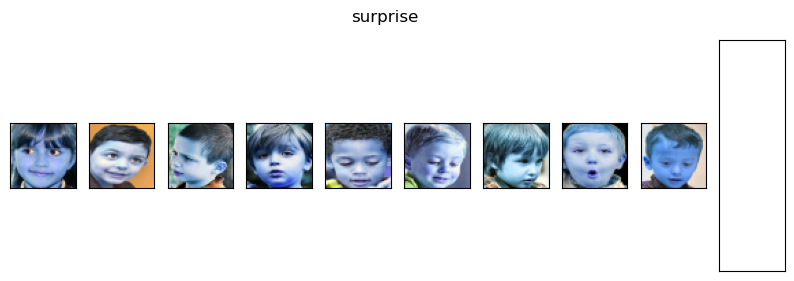

In [15]:
plot_samples(X_train, y_train, train_labels, 10)

**Encoding Classes**

Using the method to_categorical(), a numpy array (or) a vector which has integers that represent different categories, can be converted into a numpy array (or) a matrix which has binary values and has columns equal to the number of categories in the data.

In [29]:
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(y_train, num_classes=6)
Y_train.shape

(758, 6)

In [30]:
Y_test = to_categorical(y_test, num_classes=6)
Y_test.shape

(75, 6)

# **Model Building**

VGG16 is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. Most unique thing about VGG16 is that instead of having a large number of hyper-parameter they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.

![](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

In [31]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(
        weights=None,
        include_top=False, 
        input_shape=IMG_SIZE + (3,)
    )

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [32]:
NUM_CLASSES = 6

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1000, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(NUM_CLASSES, activation="softmax"))


In [33]:
epochs = 90
batch_size = 64

In [34]:
def deep_model(model, X_train, Y_train, epochs, batch_size):
   
    model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])
    
    datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
    
    history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    verbose=1)
    
    return history

In [35]:
history = deep_model(model, X_train, Y_train, epochs, batch_size)

Epoch 1/90


11/11 [==============================] - 32s 2s/step - loss: 0.6868 - accuracy: 0.4433
Epoch 2/90
11/11 [==============================] - 26s 2s/step - loss: 0.5882 - accuracy: 0.4485
Epoch 3/90
11/11 [==============================] - 26s 2s/step - loss: 0.3969 - accuracy: 0.4512
Epoch 4/90
11/11 [==============================] - 26s 2s/step - loss: 0.4025 - accuracy: 0.4406
Epoch 5/90
11/11 [==============================] - 26s 2s/step - loss: 0.3894 - accuracy: 0.4617
Epoch 6/90
11/11 [==============================] - 26s 2s/step - loss: 0.3985 - accuracy: 0.4512
Epoch 7/90
11/11 [==============================] - 26s 2s/step - loss: 0.3873 - accuracy: 0.4525
Epoch 8/90
11/11 [==============================] - 26s 2s/step - loss: 0.3932 - accuracy: 0.4710
Epoch 9/90
11/11 [==============================] - 26s 2s/step - loss: 0.3870 - accuracy: 0.4472
Epoch 10/90
11/11 [==============================] - 26s 2s/step - loss: 0.3943 - accuracy: 0.4604
Epoch 11/90
11/11

KeyboardInterrupt: 

**Confusion Matrix**

Additionally, the sensitivity, specificity, F-score, and accuracy are calculated for each class by using the following calculated confusion matrix Fig for the six classes for emotion detection. Each class is used against all classes in order to find those performance factors related to it.



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# Validate on test set

predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]


accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(test_labels.items()), normalize=False)

**Let's try our model and make predictions**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen_test = ImageDataGenerator(rescale = 1./255)
pred_generator = datagen_test.flow_from_directory(TEST_DIR,
                                                 target_size = (48,48),
                                                 color_mode = "grayscale",
                                                 batch_size = batch_size,
                                                 class_mode = "categorical",
                                                 shuffle=False)

In [19]:
new_predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in new_predictions]
y_pred = [test_labels[k] for k in y_pred]

In [20]:
filenames = pred_generator.filenames
actual_class = [test_labels[h] for h in pred_generator.classes]

In [ ]:
import pandas as pd

pred_result = pd.DataFrame({"Filename":filenames,
                           "Predictions":y_pred,
                           "Actual Values":actual_class})

pred_result.head()

In [ ]:
from random import randint

l = len(filenames)
base_path = TEST_DIR
for i in range(10):  # 10 images
    
    rnd_number = randint(0,l-1)
    filename,pred_class,actual_class = pred_result.loc[rnd_number]
    
    img_path = os.path.join(base_path,filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Predicted Class: {} {} Actual Class: {}".format(pred_class,'\n',actual_class))
    plt.show()
    pass